<a href="https://colab.research.google.com/github/Pulsar-kkaturi/Deepnoid-Education/blob/master/notebooks/Result_Visulization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Result Visulization (결과 시각화)

# 1. Library Import

In [61]:
import os, matplotlib, csv, shutil, json
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd


### Tensorflow 2.0 ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

# 2. 데이터셋 로딩

In [2]:
(x_train, y_train), (x_test, y_test)=keras.datasets.mnist.load_data(path='minist.npz')


11493376/11490434 [==============================] - 0s 0us/step


In [3]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


# 2.1 MNIST Image Array

In [6]:
x_train_list = []
x_test_list = []
for i, i_ in enumerate(x_train[:1000]):
    arr = np.zeros(shape=(32, 32))
    arr[:28,:28] = x_train[i]
    x_train_list.append(arr)
for i, i_ in enumerate(x_test[:500]):
    arr = np.zeros(shape=(32, 32))
    arr[:28,:28] = x_test[i]
    x_test_list.append(arr)

x_train1 = np.expand_dims(np.array(x_train_list), axis=-1)
x_test1 = np.expand_dims(np.array(x_test_list), axis=-1)
print(x_train1.shape, x_test1.shape)

(1000, 32, 32, 1) (500, 32, 32, 1)


## 2.2 MNIST LABEL Array

In [8]:
y_train_list = []
y_test_list = []
for i, i_ in enumerate(y_train[:1000]):
    zero = [0]*10
    zero[i_] = 1
    y_train_list.append(zero)

for i, i_ in enumerate(y_test[:500]):
    zero = [0]*10
    zero[i_] = 1
    y_test_list.append(zero)    
    
y_train1 = np.array(y_train_list)
y_test1 = np.array(y_test_list)
print(y_train1.shape, y_test1.shape)

(1000, 10) (500, 10)


## 2.3 MNIST figure

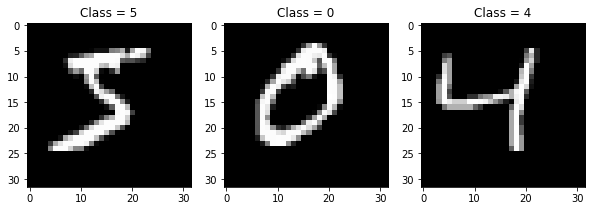

In [9]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(x_train1[i][...,0], cmap='gray')
    plt.title('Class = {}'.format(y_train[i]))

# 3. VGG Model Build

In [10]:
def conv_block_2d(lr_conv, lr_num, par_list, bkn):
        # parameter
        filter_num = par_list[0]
        conv_size = par_list[1]
        conv_act = par_list[2]
        pool_size = par_list[3]
        # code
        for i in range(lr_num):
            lr_conv = layers.Conv2D(filter_num, conv_size, activation=None, padding='same', 
                                    kernel_initializer='he_normal',
                                    name='block{}_conv{}'.format(bkn, i+1))(lr_conv)
            lr_conv = layers.BatchNormalization(axis=-1, name='block{}_batchnorm{}'.format(bkn, i+1))(lr_conv)
            lr_conv = layers.Activation(conv_act, name='block{}_activ{}'.format(bkn, i+1))(lr_conv)
        lr_pool = layers.MaxPooling2D(pool_size=pool_size, name='block{}_pool'.format(bkn, i+1))(lr_conv)
        return lr_pool

def output_block(lr_dense, block_num, dens_count, act_func, drop_rate):
    lr_dense = layers.Flatten(name='flatten_layer')(lr_dense)
    for i in range(block_num):
        lr_dense = layers.Dense(dens_count[i], kernel_regularizer=None,
                                activation=act_func, name='classifier_dense_{}'.format(i+1))(lr_dense)
        lr_dense = layers.Dropout(drop_rate, name='classifier_dropout_{}'.format(i+1))(lr_dense)
    return lr_dense

In [11]:
def VGG16_2D(par_dic):
    # parameters
    input_size = par_dic['input_size']
    conv_size = par_dic['conv_size']
    conv_act = par_dic['conv_act']
    pool_size = par_dic['pool_size']
    dens_num = par_dic['dens_num']
    dens_count = par_dic['dens_count']
    dens_act = par_dic['dens_act']
    drop_out = par_dic['drop_out']
    output_count = par_dic['output_count']
    output_act = par_dic['output_act']

    # code block
    inputs = Input(shape=(input_size, input_size, 1), name='input_layer')
    block1 = conv_block_2d(inputs, 2, [64, conv_size, conv_act, pool_size])
    block2 = conv_block_2d(block1, 2, [128, conv_size, conv_act, pool_size])
    block3 = conv_block_2d(block2, 3, [256, conv_size, conv_act, pool_size])
    block4 = conv_block_2d(block3, 3, [512, conv_size, conv_act, pool_size])
    block5 = conv_block_2d(block4, 3, [512, conv_size, conv_act, pool_size])
    dens = output_block(block5, dens_num, dens_count, dens_act, drop_out)
    outputs = layers.Dense(output_count, activation=output_act, name='output_layer')(dens)
    model = Model(inputs, outputs)
    return model

In [12]:
def VGG19_2D(par_dic):
    # parameters
    input_size = par_dic['input_size']
    conv_size = par_dic['conv_size']
    conv_act = par_dic['conv_act']
    pool_size = par_dic['pool_size']
    dens_num = par_dic['dens_num']
    dens_count = par_dic['dens_count']
    dens_act = par_dic['dens_act']
    drop_out = par_dic['drop_out']
    output_count = par_dic['output_count']
    output_act = par_dic['output_act']

    # code block
    inputs = Input(shape=(input_size, input_size, 1))
    block1 = conv_block_2d(inputs, 2, [64, conv_size, conv_act, pool_size])
    block2 = conv_block_2d(block1, 2, [128, conv_size, conv_act, pool_size])
    block3 = conv_block_2d(block2, 4, [256, conv_size, conv_act, pool_size])
    block4 = conv_block_2d(block3, 4, [512, conv_size, conv_act, pool_size])
    block5 = conv_block_2d(block4, 4, [512, conv_size, conv_act, pool_size])
    dens = output_block(block5, dens_num, dens_count, dens_act, drop_out)
    outputs = layers.Dense(output_count, activation=output_act)(dens)
    model = Model(inputs, outputs)
    return model

In [13]:
network_param_set = {'input_size': 32,
                     'conv_size': 3,
                     'conv_act': 'relu',
                     'pool_size': 2,
                     'dens_num': 2,
                     'dens_count': [1000,500],
                     'dens_act': 'relu',
                     'drop_out': 0.5,
                     'output_count': 10,
                     'output_act': 'softmax'}

In [14]:
model = VGG19_2D(network_param_set)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0     

# 4. MNIST Training

In [15]:
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(lr=1e-5), metrics=['accuracy'])

In [16]:
callback_list = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                         keras.callbacks.ModelCheckpoint(filepath=os.path.join('model.h5'),
                                                         monitor='val_loss', save_best_only=True),
                         keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)]

history = model.fit(x_train1, y_train1, epochs=50, batch_size=32, 
                    validation_data=(x_test1, y_test1),
                    callbacks=callback_list, shuffle=True)

Epoch 1/50
32/32 [==============================] - 11s 76ms/step - loss: 3.2775 - accuracy: 0.1072 - val_loss: 2.3502 - val_accuracy: 0.0740
Epoch 2/50
32/32 [==============================] - 1s 47ms/step - loss: 2.7562 - accuracy: 0.1382 - val_loss: 2.3029 - val_accuracy: 0.0860
Epoch 3/50
32/32 [==============================] - 1s 47ms/step - loss: 2.3675 - accuracy: 0.1918 - val_loss: 2.2464 - val_accuracy: 0.1300
Epoch 4/50
32/32 [==============================] - 1s 47ms/step - loss: 2.3338 - accuracy: 0.2183 - val_loss: 2.1515 - val_accuracy: 0.2460
Epoch 5/50
32/32 [==============================] - 1s 47ms/step - loss: 1.9879 - accuracy: 0.3211 - val_loss: 2.0218 - val_accuracy: 0.3620
Epoch 6/50
32/32 [==============================] - 1s 47ms/step - loss: 1.8576 - accuracy: 0.3604 - val_loss: 1.8764 - val_accuracy: 0.4500
Epoch 7/50
32/32 [==============================] - 2s 51ms/step - loss: 1.6941 - accuracy: 0.4044 - val_loss: 1.7402 - val_accuracy: 0.5080
Epoch 8/50
3

# 5. Train Result

## 5.1. Loss & Accuracy

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

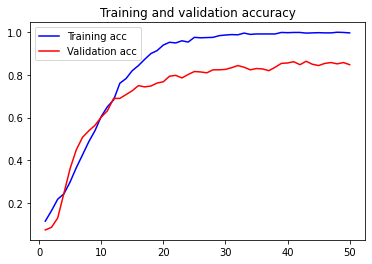

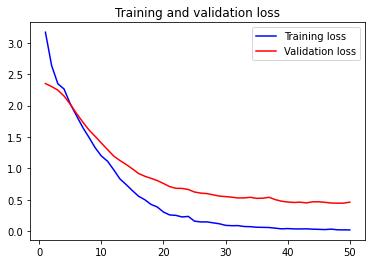

In [20]:
plt.plot(epochs, acc, 'b', color='blue', label='Training acc')
plt.plot(epochs, val_acc, 'b', color='red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##5.2. Prediction Result

(32, 32, 1)


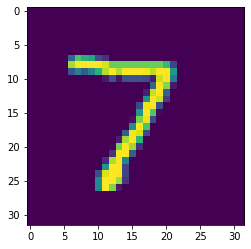

In [33]:
test1 = x_test1[0]
print(test1.shape)
plt.imshow(test1[...,0])

In [40]:
test1p = test1[np.newaxis,...]
score1 = model.predict(test1p)
print(test1p.shape)
print(score1)

new_score1 = []
for i, i_ in enumerate(score1[0]):
  if i_ < 0.5:
    new_score1.append(0)
  else:
    new_score1.append(1)
  
print(new_score1)

(1, 32, 32, 1)
[[2.3480409e-06 5.0351198e-05 1.7237573e-05 6.4310775e-06 1.5670896e-05
  2.5316976e-06 8.8501220e-06 9.9988091e-01 4.0981736e-06 1.1501858e-05]]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


## 5.3. Class Attention Map

In [55]:
from keras.applications.vgg16 import VGG16
image_model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 5s 0us/step


In [62]:
elephants = image_model.output[:, 386]
image_conv_layer = image_model.get_layer('block5_conv3')
print(elephants)
grads = K.gradients(elephants, image_conv_layer.output)[0]

KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.float32, name=None), name='tf.__operators__.getitem_14/strided_slice:0', description="created by layer 'tf.__operators__.getitem_14'")


RuntimeError: ignored

In [58]:
seven_output = model.output[:, 7]
last_conv_layer = model.get_layer('conv2d_15')

print(seven_output)

grads = K.gradients(elephants, last_conv_layer.output)[0]

KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.float32, name=None), name='tf.__operators__.getitem_11/strided_slice:0', description="created by layer 'tf.__operators__.getitem_11'")


RuntimeError: ignored